进入12题查看数据，任务是抓取五页的数字，计算加和并提交结果  
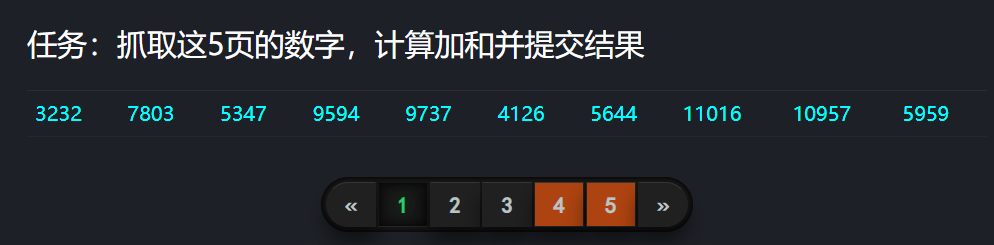

In [135]:
# 1.尝试获取数据
! pip install requests
import requests

url = "https://match.yuanrenxue.com/match/12"
session = requests.Session()
resp = session.get(url)
print(resp.status_code,len(resp.text))

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
200 35021


分析：数据都在表格之内，尝试获取数据  
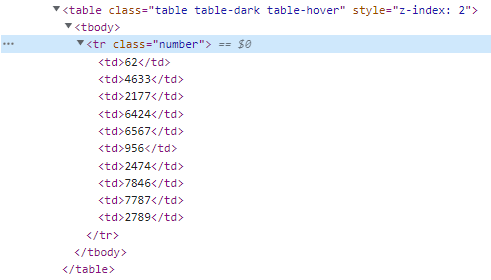

In [136]:
# 2. 尝试获取数据
# 全部数据都在一个`tr`标签中，尝试用re模块定位
! pip install lxml
from lxml import etree

html = etree.HTML(resp.text)
table = html.xpath("/html/body/div/div[2]/table/tbody/tr")

data = []
for td in table:
    data.append(td.xpath("./td/text()"))
data

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


[['150', '150', '150', '150', '150', '150', '150', '150', '150', '150']]

## 不出意外，数据有问题，检查参数  

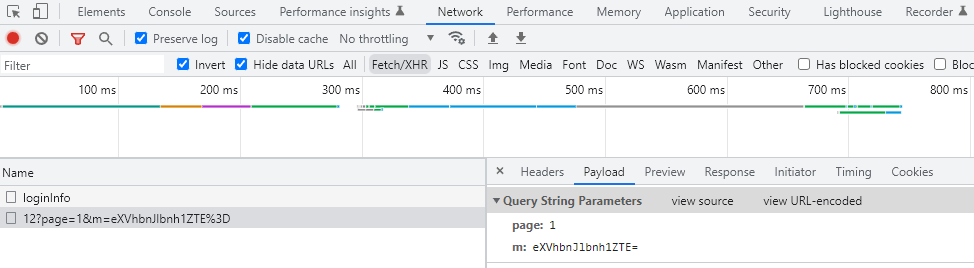
## 发现有两个参数传递,尝试解析参数生成过程  

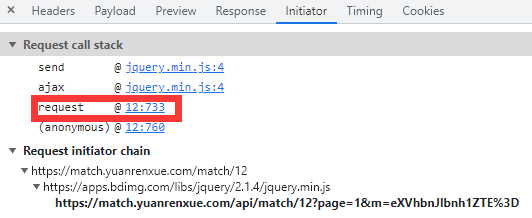
## 选择request定位到js代码中

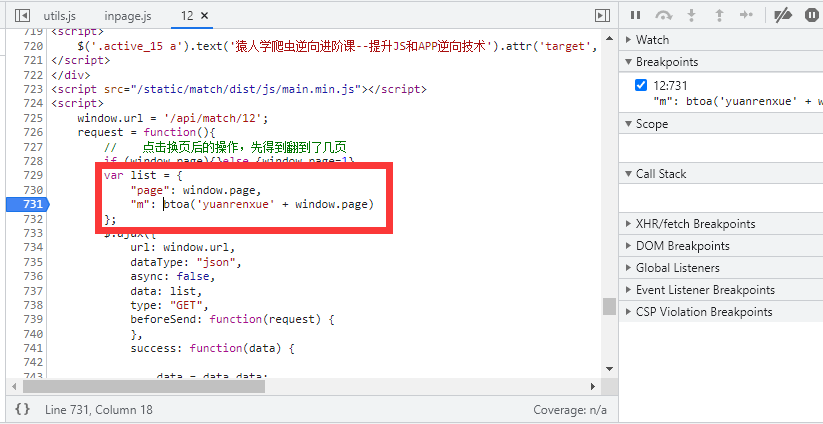
## 发现参数的定义就在其中
逻辑是先得到`window.page`参数，然后根据固定文本`yuanrenxue`+参数值到`btoa`函数中生成  
btoa函数没有重写，全名`window.btoa`，既然是全局变量就可以直接使用`btoa`引用，`window.btoa`是js代码中的`base64`加密方式的加密过程

## 新的开始
首先我们得生成我们需要页面的页码，即`page`  
其次是把固定文本`yuanrenxue`+生成的页码`page`放入`btoa`之中取得参数`m`  
最后访问时传入`page`和`m`函数  

In [137]:
# 2.1. 尝试生成参数
import base64
from urllib.parse import quote

def build_m(num):
    # 字符串组合
    _str = 'yuanrenxue' + num
    # 对字符串转换成ASCLL码
    _str = _str.encode('utf-8')
    # 解析编码后的数据
    enstr = base64.b64encode(_str).decode('utf-8')
    # 返回url编码的数据
    return enstr


def build_params(num):
    num = str(num)
    return {'page':num,'m':build_m(num)}

params = build_params(1)
params

{'page': '1', 'm': 'eXVhbnJlbnh1ZTE='}

In [138]:
# 2.2 再次尝试访问
url = 'https://match.yuanrenxue.com/api/match/12'

resp = session.get(
    url=url,
    params=params,
    )
resp.json()

{'status': '1',
 'state': 'success',
 'data': [{'value': 62},
  {'value': 4633},
  {'value': 2177},
  {'value': 6424},
  {'value': 6567},
  {'value': 956},
  {'value': 2474},
  {'value': 7846},
  {'value': 7787},
  {'value': 2789}]}

In [139]:
# 2.3 批量访问
for n in range(1,6):
    params = build_params(n)
    resp = session.get(
        url=url,
        params=params,
        # headers=headers,
    )
    print(resp.json())
    

{'status': '1', 'state': 'success', 'data': [{'value': 62}, {'value': 4633}, {'value': 2177}, {'value': 6424}, {'value': 6567}, {'value': 956}, {'value': 2474}, {'value': 7846}, {'value': 7787}, {'value': 2789}]}
{'status': '1', 'state': 'success', 'data': [{'value': 4542}, {'value': 9173}, {'value': 8246}, {'value': 4449}, {'value': 8026}, {'value': 374}, {'value': 4610}, {'value': 2916}, {'value': 9066}, {'value': 2618}]}
{'status': '1', 'state': 'success', 'data': [{'value': 5150}, {'value': 2325}, {'value': 5170}, {'value': 986}, {'value': 6206}, {'value': 6412}, {'value': 5985}, {'value': 9476}, {'value': 4302}, {'value': 8450}]}


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

## 前三页访问正常，检查页面访问的特殊的规则

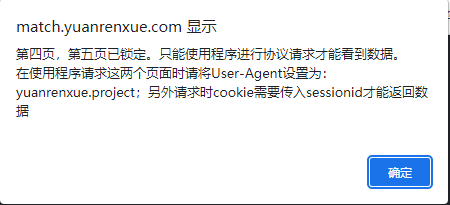

In [149]:
# 2.4 按照规则修改请求后访问
for n in range(1,4):
    params = build_params(n)
    resp = session.get(
        url=url,
        params=params,
        # headers=headers,
    )
    print(resp.json())

headers = {"user-agent": "yuanrenxue.project"}
cookies = {'sessionid':'ywsl9kicbly7aw6rkizdudb3bns0phf5'}
for n in [4,5]:
    
    params = build_params(n)
    resp = session.get(
        url=url,
        params=params,
        headers=headers,
        cookies=cookies
    )
    print(resp.json())

{'status': '1', 'state': 'success', 'data': [{'value': 62}, {'value': 4633}, {'value': 2177}, {'value': 6424}, {'value': 6567}, {'value': 956}, {'value': 2474}, {'value': 7846}, {'value': 7787}, {'value': 2789}]}
{'status': '1', 'state': 'success', 'data': [{'value': 4542}, {'value': 9173}, {'value': 8246}, {'value': 4449}, {'value': 8026}, {'value': 374}, {'value': 4610}, {'value': 2916}, {'value': 9066}, {'value': 2618}]}
{'status': '1', 'state': 'success', 'data': [{'value': 5150}, {'value': 2325}, {'value': 5170}, {'value': 986}, {'value': 6206}, {'value': 6412}, {'value': 5985}, {'value': 9476}, {'value': 4302}, {'value': 8450}]}
{'status': '1', 'state': 'success', 'data': [{'value': 12125}, {'value': 5932}, {'value': 5016}, {'value': 11490}, {'value': 11349}, {'value': 9821}, {'value': 5319}, {'value': 10387}, {'value': 4742}, {'value': 4146}]}
{'status': '1', 'state': 'success', 'data': [{'value': 4403}, {'value': 11213}, {'value': 8768}, {'value': 13103}, {'value': 7850}, {'val

In [150]:
# 3. 提取数据并进行加和

headers = {"user-agent": "yuanrenxue.project"}
cookies = {'sessionid':'ywsl9kicbly7aw6rkizdudb3bns0phf5'}
nums = []

for n in range(1,6):
    params = build_params(n)
    resp = session.get(
        url=url,
        params=params,
        headers=headers,
        cookies=cookies
    )
    nums.extend(v['value'] for v in resp.json()['data'])
num = sum(nums)
num

405582

In [151]:
# 3.1 提交答案
url = "https://match.yuanrenxue.com/api/answers"
params = {'answer':num,'id':12}
resp = session.get(url,params=params,cookies=cookies)
resp.json()

{'user': 'sancho', 'info': 'success', 'status_code': '1'}